In [1]:
! git clone https://github.com/hdspgroup/DeepLDSIR
%cd DeepLDSIR

Cloning into 'DeepLDSIR'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 69 (delta 25), reused 44 (delta 10), pack-reused 0
Unpacking objects: 100% (69/69), done.
/content/DeepLDSIR


In [2]:
import sys
sys.path.insert(0, './models')

In [3]:
import tensorflow as tf
import numpy as np
import scipy.io as sio

from utils import *
from models.Alpha8L import *
from matplotlib import pyplot as plt
from admm import ADMM as algADMM

In [5]:
data_path = "./data/Image_28.mat"

RGB = [22, 12, 4]
h = sio.loadmat(data_path)['img']
h = np.expand_dims(h,0)         
Batch_size, Img_heigth , Img_width , Channels = h.shape                
coded_aperture = np.load('ca.npy')

y = dd_cassi(h,coded_aperture)

In [6]:
print(coded_aperture.shape)

(1, 512, 542, 1, 1)


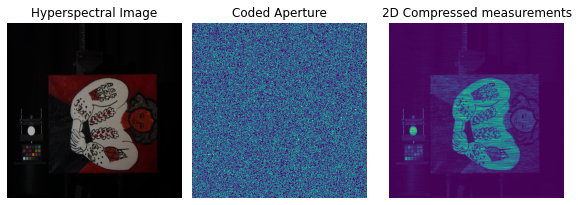

In [7]:
fig, axs = plt.subplots(1,3,constrained_layout=True , figsize=(8,3))
_ = [ x.axis('Off') for x in axs]

axs[0].imshow(h[0,:,:,:][:,:,RGB]) , axs[0].set_title('Hyperspectral Image')
axs[1].imshow(coded_aperture[0,:,:,0,0], aspect=1.06) , axs[1].set_title('Coded Aperture')
axs[2].imshow(y[0,:,:,0]), axs[2].set_title('2D Compressed measurements')
plt.show()

In [8]:
input_size = (Img_heigth, Img_width, Channels)
weights = './weights/Alpha8L_Kaist.h5'

In [9]:
optimizad = tf.keras.optimizers.Adam(learning_rate=1e-4)

main_model = HSI_net(coded_aperture, input_size=input_size,  pretrained_weights=weights)

autoencoder = main_model.autoencoder
encode = main_model.encoder
decode = main_model.decoder

autoencoder.compile(optimizer=optimizad, loss='mean_squared_error')
encode.compile(optimizer=optimizad, loss='mean_squared_error')
decode.compile(optimizer=optimizad, loss='mean_squared_error')

In [10]:
algorit_admm = algADMM(main_model)
epochs , steps = 200 , 20
params = [1 , 0.1 , 0.3]

In [11]:
h_est = algorit_admm(y,epochs,steps,params)

||temp-t_old||152.49652087708313||temp2-t2_old||216.21081054652393
||temp-t_old||27.274485||temp2-t2_old||29.796057
||temp-t_old||15.270569||temp2-t2_old||17.96564
||temp-t_old||7.6829123||temp2-t2_old||12.128765
||temp-t_old||5.096537||temp2-t2_old||8.185472
||temp-t_old||3.8496096||temp2-t2_old||5.698692
||temp-t_old||3.2355676||temp2-t2_old||4.124577
||temp-t_old||2.8229902||temp2-t2_old||2.9184155
||temp-t_old||2.615733||temp2-t2_old||2.1640303
||temp-t_old||2.5158393||temp2-t2_old||1.7296747
||temp-t_old||2.4783008||temp2-t2_old||1.418228
||temp-t_old||2.5001948||temp2-t2_old||1.2409718
||temp-t_old||2.5304623||temp2-t2_old||1.147492
||temp-t_old||2.5685594||temp2-t2_old||1.0245979
||temp-t_old||2.6031437||temp2-t2_old||0.96492577
||temp-t_old||2.6425183||temp2-t2_old||0.92342615
||temp-t_old||2.6783202||temp2-t2_old||0.90134084
||temp-t_old||2.6895506||temp2-t2_old||0.8843174
||temp-t_old||2.7090983||temp2-t2_old||0.87578505
||temp-t_old||2.7427735||temp2-t2_old||0.8546177
recons

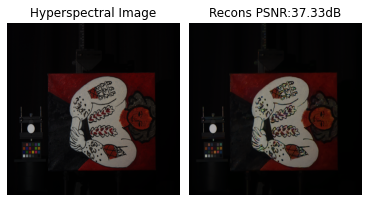

In [12]:
psnr = round( tf.image.psnr(h,h_est,1).numpy()[0],2)

fig, axs = plt.subplots(1,2,constrained_layout=True , figsize=(5,3))
_ = [ x.axis('Off') for x in axs]

axs[0].imshow(h[0,:,:,:][:,:,RGB]) , axs[0].set_title('Hyperspectral Image')
axs[1].imshow(h_est[0,:,:,:][:,:,RGB]) , axs[1].set_title('Recons PSNR:' + str(psnr) + 'dB')

plt.show()